In [15]:
import numpy as np
import pandas as pd
import os, os.path
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt
import cv2

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

#keras
from keras import optimizers
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Dropout, Flatten


import warnings
warnings.filterwarnings("ignore")

# 資料整理

In [16]:
newpath=r'rename_train'
img_desc = pd.read_csv('img_description.csv')
img_desc.head(5)

,class,img,name
0,12,bedroom_0001.jpg,bedroom
1,12,bedroom_0002.jpg,bedroom
2,12,bedroom_0003.jpg,bedroom
3,12,bedroom_0004.jpg,bedroom
4,12,bedroom_0005.jpg,bedroom


# 顯示圖片

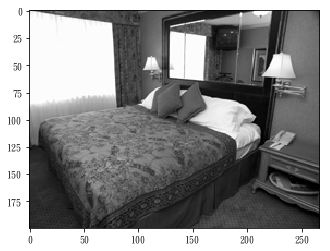

In [17]:
img = cv2.imread(newpath + '/'+img_desc.img.iloc[0], 0)
plt.imshow(img, cmap="gray")

In [18]:
img_desc['class'].value_counts()



6     310
8     274
10    260
13    256
4     228
11    215
2     211
3     208
1     192
5     189
14    160
9     141
12    116
7     115
0     110
Name: class, dtype: int64

# 資料前處理
  - 將圖片做Resize
  - label做one-hot
  - 資料切割
  - 顯示切割後的圖片

In [19]:
#將label做 one_hot encoding
img_y = pd.get_dummies(img_desc['class']).as_matrix()

# 圖片大小resize為 200 x 200

In [20]:
#參數設定
sz=200 #resize scale
batch_size=64
epochs=100
epochs_gen=8

In [21]:
resize_img=np.ndarray(shape=(len(img_desc['img']),sz,sz))
for i in range(len(img_desc['img'])):
    dir_=newpath + '/'+str(img_desc['img'].iloc[i])
    image=cv2.imread(dir_, 0) #讀取圖片
    image=cv2.resize(image,(sz,sz)) #設定為50*50
    resize_img[i]=image


In [22]:
x_data, y_label = resize_img, img_y #資料切割

print("[info] 原始數據維度")
print("[info]",x_data.shape)
print("[info]",y_label.shape)
print("---------")

x_data = x_data.reshape(resize_img.shape[0],sz,sz,1) / 255 # normalize

[info] 原始數據維度
[info] (2985, 200, 200)
[info] (2985, 15)
---------


In [23]:
#資料分為訓練與測試資料
x_train, x_test, y_train, y_test = train_test_split(x_data, 
                                                    y_label, 
                                                    test_size = 0.25, 
                                                    stratify  = y_label)

#再把validion set切割
x_train, x_valid, y_train, y_valid = train_test_split(x_data, 
                                                      y_label, 
                                                      test_size = 0.1,
                                                      stratify = y_label.argmax(axis = 1))
print("[info] ", x_train.shape, y_train.shape, x_test.shape, y_test.shape)

[info]  (2686, 200, 200, 1) (2686, 15) (747, 200, 200, 1) (747, 15)


# Model 

# Conv + Maxpooling

In [24]:
model = Sequential()
# Conv + Max-pooling 1
model.add(Conv2D(filters=32,kernel_size=(3,3),padding='same', input_shape=(sz,sz,1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


# Conv + Max-pooling 2
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


# Conv + Max-pooling 3
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

# Flatten + Dense

In [25]:
# Flatten層: 壓成一維
# Dense 接在內層不用input_dim，其他參數先用預設值
model.add(Flatten())
model.add(Dense(1024, activation='relu', kernel_initializer='normal'))
model.add(Dropout(0.5))

#最後節點設定為15 (15 classes)
model.add(Dense(15,activation='softmax'))

In [26]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 200, 200, 32)      320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 100, 100, 64)      18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 50, 50, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 25, 25, 128)       0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 25, 25, 128)       0         
__________

# Optimizer


In [27]:
adam = optimizers.adam(lr=0.001)
RMSprop = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-06)
model.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])

# EarlyStopping & Ckeckpoint & ReduceLR

In [28]:
from keras.callbacks import EarlyStopping 
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
#保存模型與參數
#注意容量 !!
cp_path="weights-improvement-best-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(cp_path, monitor='val_loss', verbose=0, save_best_only=True, mode='min')

#當val_loss沒有在下降則中斷訓練設定 check 5 epochs
early_stop = EarlyStopping(monitor='val_loss', patience=5, mode='min') 

#設定val_loss 該數值在參數patience=5，等待五次 無表現好則改變learning rate
ReduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0,mode='auto',epsilon=0.0001,
                             cooldown=0,min_lr=0)



# ImageDataGenerator
  - 由於資料量不夠 Training Data(2985, 50, 50) -> x_train(2686, 50, 50)
  
  
  - 選用ImageDataGenerator以batch形式增加數據，訓練時會無限生成數據，直到達到規定的epoch次數為止。

In [29]:
dummy_dat = np.zeros((x_train.shape[0],sz,sz,1), dtype=np.float32)
dataAugment  = True #設定flag

if(dataAugment): from keras.preprocessing.image import ImageDataGenerator
if(dataAugment):
    fudge_X_train = np.concatenate((x_train, dummy_dat), axis = 3)
    '''
    param rotation_range : 提升圖片隨機轉動角度
    param horizontal_flip : 隨機翻轉
    param vertical_flip : 隨機數值翻轉
    param width_shift_range : 寬度比例，提升圖片水平偏移幅度
    param height_shift_range : 高度比例，提升圖片豎直偏移幅度
    param zoom_range : 隨機縮放
    param fill_mode : 超出邊界時的設定
    '''
    train_datagen = ImageDataGenerator(rotation_range=0.90,horizontal_flip=True,vertical_flip=True,
                                    width_shift_range=0.2,height_shift_range=0.2,zoom_range=0.2,fill_mode='nearest')
    
    train_datagen.fit(fudge_X_train)
    x_batches=fudge_X_train
    y_batches=y_train
    #設定ImageDataGenerator epoch
    for e in range(epochs_gen):
        #print('Data Gene epochs =',e)
        batches=0
        per_batch=batch_size
        #每次的batch_size生成數據
        for x_batch,y_batch in train_datagen.flow(fudge_X_train,y_train,batch_size=batch_size):
            x_batches = np.concatenate((x_batches, x_batch), axis = 0)
            y_batches = np.concatenate((y_batches, y_batch), axis = 0)

            batches += 1
            if batches >= len(fudge_X_train) / per_batch:
            # 需要手動break loop
            # we need to break the loop by hand because
            # the generator loops indefinitely
                break
    x_train_new = x_batches[:,:,:,:1]
    print('Data Augment(x_train_new) total shape =',x_train_new.shape)
    print('Data Augment(y) total shape =',y_batches.shape)
    print("-------------------")


steps_per_epoch=int((len(x_train_new)*2)/batch_size)
print("steps_per_epoch={}".format(x_train_new.shape))
print("trainLabels.shape={}".format(y_batches.shape))
print("steps_per_epoch={}".format(steps_per_epoch))

if(dataAugment):
    
    history=model.fit_generator(train_datagen.flow(x_train_new,y_batches,batch_size=batch_size),
                                                steps_per_epoch=steps_per_epoch,epochs=epochs,
                                                    validation_data=(x_valid, y_valid),
                                                    callbacks=[early_stop,ReduceLR])
    print(history)
else:
    history=model.fit(x_train, y_train, validation_split=0.2, epochs=epochs, batch_size=batch_size, verbose=2)

Data Augment(x_train_new) total shape = (24174, 200, 200, 1)
Data Augment(y) total shape = (24174, 15)
-------------------
steps_per_epoch=(24174, 200, 200, 1)
trainLabels.shape=(24174, 15)
steps_per_epoch=755
Epoch 1/100
755/755 [==============================] - 93s - loss: 1.8475 - acc: 0.3688 - val_loss: 1.0954 - val_acc: 0.6355
Epoch 2/100
755/755 [==============================] - 87s - loss: 1.2387 - acc: 0.5734 - val_loss: 0.9589 - val_acc: 0.6923
Epoch 3/100
755/755 [==============================] - 88s - loss: 1.0371 - acc: 0.6390 - val_loss: 0.8903 - val_acc: 0.7458
Epoch 4/100
755/755 [==============================] - 88s - loss: 0.9322 - acc: 0.6739 - val_loss: 0.9346 - val_acc: 0.6856
Epoch 5/100
755/755 [==============================] - 87s - loss: 0.8554 - acc: 0.7004 - val_loss: 0.8407 - val_acc: 0.7358
Epoch 6/100
755/755 [==============================] - 86s - loss: 0.7823 - acc: 0.7270 - val_loss: 0.7281 - val_acc: 0.7759
Epoch 7/100
755/755 [===================


  - 生成後資料量從 2686-> 42976筆 


# 顯示圖表

In [30]:
def plot_train_history(history, train_metrics, val_metrics):
    plt.plot(history.history.get(train_metrics),'-o')
    plt.plot(history.history.get(val_metrics),'-o')
    plt.ylabel(train_metrics)
    plt.xlabel('Epochs')
    plt.legend(['train', 'validation'])

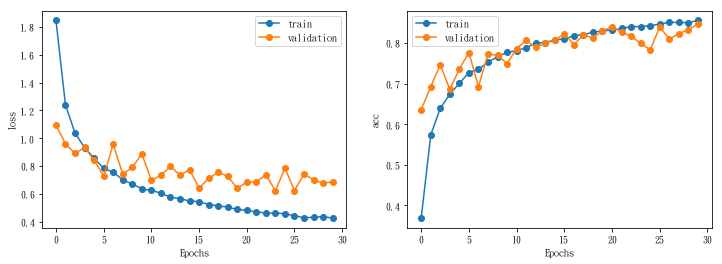

In [31]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plot_train_history(history, 'loss','val_loss')
plt.subplot(1,2,2)
plot_train_history(history, 'acc','val_acc')
plt.show()

In [32]:
loss, accuracy = model.evaluate(x_valid, y_valid)
print("\nLoss: %.2f, Accuracy: %.2f%%" % (loss, accuracy*100))

299/299 [==============================] - 0s     

Loss: 0.69, Accuracy: 84.62%


In [33]:
testdata=pd.read_csv("img-submission.csv")
id_list = [] 

test_dir="testset"
test_img=np.ndarray(shape=(len(testdata['id']),sz,sz))
for i in range(len(testdata)):
 
    dir_=test_dir + '/'+str(testdata['id'].iloc[i]+".jpg")
    image=cv2.imread(dir_, 0)
    image=cv2.resize(image,(sz,sz))
    test_img[i]=image
    id_list.append(testdata['id'].iloc[i])
    
test_img=test_img.reshape(test_img.shape[0],sz,sz,1) / 255
pred_test=model.predict_classes(test_img)

submission = pd.DataFrame({"id":id_list,"class":pred_test}) 
submission.head(5)


1500/1500 [==============================] - 1s     


,class,id
0,12,c117693e1cf24a5232090d1548cb11d4e5ea0df65680c4...
1,14,96baacc2e97886a998807ce197574821a6dc83c227c746...
2,12,f9bd26db23eb9b544ca78be79b11b4d1259e802885861d...
3,12,b42bcd8e6645fcc2ac40ee44b7dc8d74a77081d0aea7a1...
4,2,5bc53cef9168882f0ff67a81b3e7269f62b7fd5343d06d...


In [34]:
submission.to_csv("ans.csv",index = False, columns = ["id","class"]) # 輸出結果到 csv 檔

%%html
<img src="mysubmission(0.77).png">

Model prediction: 12


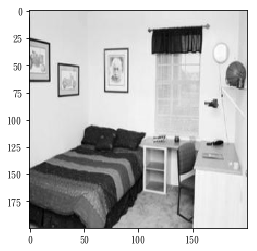

Model prediction: 14


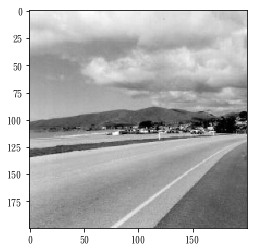

Model prediction: 12


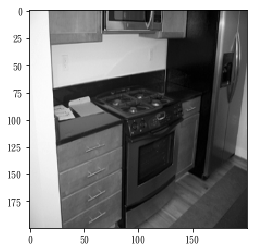

Model prediction: 12


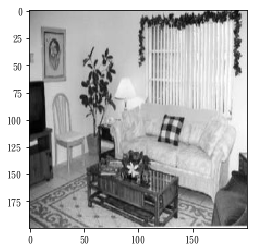

Model prediction: 2


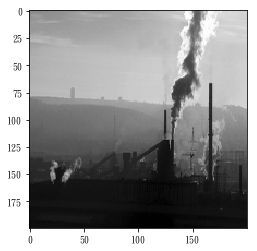

In [35]:
# Display
for i in range(5):
    print("Model prediction:", pred_test[i])
    plt.imshow(np.reshape(test_img[i], [sz, sz]), cmap='gray')
    plt.show()



In [36]:
# !jupyter nbconvert --to script keras_data_augment.ipynb